### Using a ViT pre-trained model

Sources:
1. https://www.kaggle.com/code/lizhecheng/vision-transformer-vit-resnet-baseline/notebook
2. https://github.com/AarohiSingla/Image-Classification-Using-Vision-transformer/blob/main/image_classifier_from_scratch.ipynb
3. https://colab.research.google.com/github/pashanitw/pytorch_examples/blob/main/transformer/VisionTransformer.ipynb#scrollTo=19ec9440213a820a
4. https://www.kaggle.com/code/abhinand05/vision-transformer-vit-tutorial-baseline


In [1]:
!pip install timm
!pip install transformers

In [2]:
import numpy as np
import pandas as pd

import os

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import timm
import cv2
import torch.optim as optim
import torchvision.models as models
import torchvision

from PIL import Image
from tqdm.notebook import tqdm
from sklearn import model_selection, metrics
from torch.utils.data import DataLoader
from tqdm import tqdm
from transformers import ViTModel
from torch.optim.lr_scheduler import StepLR
from transformers import ViTForImageClassification, ViTConfig
from statistics import mean
from torchvision import transforms,datasets
from torchvision.datasets import CIFAR10

plt.style.use('fivethirtyeight')

### Parameters

In [3]:
IMG_SIZE = 224
BATCH_SIZE = 95
LR = 1e-4
EPOCHS = 10
num_classes = 10

mean = [0.485, 0.456, 0.406]

std = [0.229, 0.224, 0.225]


### Trying with CIFAR10 dataset
Source: https://colab.research.google.com/github/pashanitw/pytorch_examples/blob/main/transformer/VisionTransformer.ipynb#scrollTo=19ec9440213a820a

In [4]:
NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir:str,
    test_dir:str,
    transform:transforms.Compose,
    batch_size:int,
    num_workers:int = NUM_WORKERS
):
# Use image folder to create datasets
  train_data = datasets.ImageFolder(train_dir, transform = transform)
  test_data = datasets.ImageFolder(test_dir, transform = transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into dataloaders
  train_dataloader = DataLoader(
      train_data,
      batch_size = batch_size,
      shuffle = True,
      num_workers = num_workers,
      pin_memory = True,
  )

  test_dataloader = DataLoader(
        test_data,
        batch_size=batch_size,
        shuffle = False,
        num_workers=num_workers,
        pin_memory = True,
    )
  return train_dataloader, test_dataloader,class_names



In [5]:
# Cretae image size
IMG_SIZE = 224

# Create transforme pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [6]:
# BATCH_SIZE = 128

DATA_DIR = "../data"

# Define the transform for testing dataset:
# 1. Convert images to tensors
# 2. Normaliaze the tensors using the mean and standard deviation of CIFAR10 dataset

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784])
])

# Define the transformation for training dataset:
# 1. Apply random horizontal flip for data augmentation.
# 2. Perform random resizing and cropping of images for data augmentation.
# 3. Convert images to tensors.
# 4. Normalize the tensors using the mean and standard deviation of CIFAR10 dataset.
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop((224, 224), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784])
])

# Load the CIFAR10 training dataset with the defined training transformation.
# The dataset will be downloaded if not present in the DATA_DIR.
train_dataset = CIFAR10(root=DATA_DIR, train=True, transform=train_transform, download=True)

# Load the CIFAR10 testing dataset with the defined testing transformation.
# The dataset will be downloaded if not present in the DATA_DIR.
test_set = CIFAR10(root=DATA_DIR, train=False, transform=test_transform, download=True)

# Split the training dataset into training and validation sets.
# The training set will have 45000 images, and the validation set will have 5000 images.
train_set, val_set = torch.utils.data.random_split(train_dataset, [45000, 5000])

Files already downloaded and verified
Files already downloaded and verified


In [7]:
# Define the batch size for training, validation, and testing.
batch_size = BATCH_SIZE

# Define the number of subprocesses to use for data loading.
num_workers = 2

# Create a DataLoader for the training and validation dataset:
# 1. Shuffle the training data for each epoch.
# 2. Drop the last batch if its size is not equal to `batch_size` to maintain consistency.
train_loader = torch.utils.data.DataLoader(dataset=train_set,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=num_workers,
                                           drop_last=True)

# Do not drop any data; process all the validation data.
val_loader = torch.utils.data.DataLoader(dataset=val_set,
                                         batch_size=batch_size,
                                         shuffle=False,
                                         num_workers=num_workers,
                                         drop_last=False)

# Create a DataLoader for the testing dataset:
# Do not drop any data; process all the test data.
test_loader = torch.utils.data.DataLoader(dataset=test_set,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          num_workers=num_workers,
                                          drop_last=False)


In [8]:
transforms_train = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.2),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomResizedCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

transforms_val = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

torch.Size([3, 224, 224]) tensor(4)


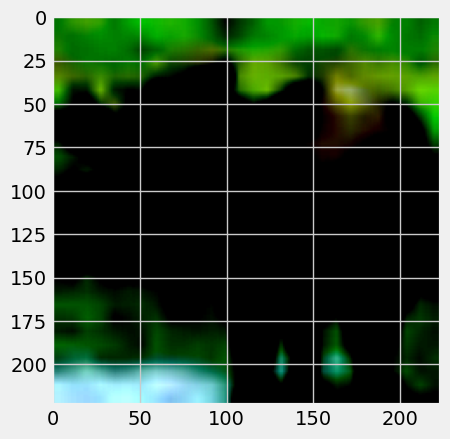

In [9]:
# Let's visualize a image in order to know if data is loaded properly or not

# Get a batch of images
image_batch, label_batch = next(iter(train_loader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
print(image.shape, label)

# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
# plt.title(class_names[label])
# plt.axis(False);

### Pre-trained ViT model
Source: https://www.kaggle.com/code/lizhecheng/vision-transformer-vit-resnet-baseline/notebook

### Using custom patch embedding layer from this source:
https://github.com/AarohiSingla/Image-Classification-Using-Vision-transformer/blob/main/image_classifier_from_scratch.ipynb

In [10]:
### Create patch embeddings

class MyPatch_Embedding(nn.Module):
  def __init__(self,in_channels:int = 3, patch_size:int = 16, embedding_dim: int = 768):
    super().__init__()

    # 3. Create a layer to turn an image into patches
    self.patcher = nn.Conv2d(in_channels = in_channels,
                             out_channels = embedding_dim,
                             kernel_size = patch_size,
                             stride = patch_size,
                             padding = 0)
    # 4. Cretae a layer to flatten the patch feature maps into a single dimension
    self.flatten = nn.Flatten(start_dim=2, end_dim = 3)  # only flatten the feature map dimension into a single vector

  # 5. Define the forward method
  def forward(self,x):
    # Create assertion to check that inputs are the correct shape
    image_resolution = x.shape[-1]    ## 32 in this case when the image size is 32
    # assert image_resolution%patch_size == 0, f"Input image size must be divisible by patch size, image size: {image_resolution}"

    # Perform the forward pass
    x_patched = self.patcher(x)
    x_flattened = self.flatten(x_patched)

    # Make sure the output shape has the right order
    return x_flattened.permute(0,2,1)
    # return x_patched
    # return image_resolution
    # return x_flattened

#### ViT pretrained model with custom patch embedding layer and a linear layer at the end.

In [11]:
class ViTBase16(nn.Module):
  def __init__(self,n_classes, pretrained = True):
    super(ViTBase16, self).__init__()
    self.model = timm.create_model("vit_base_patch16_224", pretrained = True)
    # Changing this from the original notebook. I am keeping this as pretrained = True
    self.model.patch_embed = MyPatch_Embedding()

    self.model.head = nn.Linear(self.model.head.in_features,n_classes)

  def forward(self,x):
    x = self.model(x)
    return x

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"


model = ViTBase16(n_classes = 10, pretrained = True)
model.to(device)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


ViTBase16(
  (model): VisionTransformer(
    (patch_embed): MyPatch_Embedding(
      (patcher): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (flatten): Flatten(start_dim=2, end_dim=3)
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
model.to(device)
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[80, 130], gamma=0.1)


### Training loop

In [16]:
num_epochs = 20 # example value, adjust as needed

for epoch in range(num_epochs):

    # Training Phase
    model.train()
    total_loss = 0.0
    for inputs,labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # print("These are the output shapes: ",outputs.shape)
        # print("These are the labels: ", labels.shape)
        # print(labels.shape)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}")

    # Validation Phase
    model.eval()
    total_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            total_val_loss += loss.item()

            _, predicted = outputs.max(dim=-1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # Update the learning rate
    lr_scheduler.step()

print("Training complete!")

100%|██████████| 473/473 [07:24<00:00,  1.06it/s]


Epoch [1/20], Training Loss: 1.6349


100%|██████████| 53/53 [00:18<00:00,  2.85it/s]


Epoch [1/20], Validation Loss: 1.2554, Validation Accuracy: 54.40%


100%|██████████| 473/473 [07:22<00:00,  1.07it/s]


Epoch [2/20], Training Loss: 1.1374


100%|██████████| 53/53 [00:19<00:00,  2.75it/s]


Epoch [2/20], Validation Loss: 1.0285, Validation Accuracy: 62.42%


100%|██████████| 473/473 [07:22<00:00,  1.07it/s]


Epoch [3/20], Training Loss: 0.9405


100%|██████████| 53/53 [00:18<00:00,  2.86it/s]


Epoch [3/20], Validation Loss: 0.8300, Validation Accuracy: 69.96%


100%|██████████| 473/473 [07:22<00:00,  1.07it/s]


Epoch [4/20], Training Loss: 0.8160


100%|██████████| 53/53 [00:18<00:00,  2.87it/s]


Epoch [4/20], Validation Loss: 0.7872, Validation Accuracy: 72.50%


100%|██████████| 473/473 [07:23<00:00,  1.07it/s]


Epoch [5/20], Training Loss: 0.7281


100%|██████████| 53/53 [00:18<00:00,  2.91it/s]


Epoch [5/20], Validation Loss: 0.7548, Validation Accuracy: 73.20%


100%|██████████| 473/473 [07:24<00:00,  1.06it/s]


Epoch [6/20], Training Loss: 0.6602


100%|██████████| 53/53 [00:18<00:00,  2.93it/s]


Epoch [6/20], Validation Loss: 0.6941, Validation Accuracy: 75.52%


100%|██████████| 473/473 [07:23<00:00,  1.07it/s]


Epoch [7/20], Training Loss: 0.6098


100%|██████████| 53/53 [00:19<00:00,  2.77it/s]


Epoch [7/20], Validation Loss: 0.6125, Validation Accuracy: 78.72%


100%|██████████| 473/473 [07:23<00:00,  1.07it/s]


Epoch [8/20], Training Loss: 0.5569


100%|██████████| 53/53 [00:18<00:00,  2.80it/s]


Epoch [8/20], Validation Loss: 0.6358, Validation Accuracy: 78.00%


100%|██████████| 473/473 [07:23<00:00,  1.07it/s]


Epoch [9/20], Training Loss: 0.5125


100%|██████████| 53/53 [00:18<00:00,  2.86it/s]


Epoch [9/20], Validation Loss: 0.6256, Validation Accuracy: 78.06%


100%|██████████| 473/473 [07:23<00:00,  1.07it/s]


Epoch [10/20], Training Loss: 0.4764


100%|██████████| 53/53 [00:18<00:00,  2.86it/s]


Epoch [10/20], Validation Loss: 0.5434, Validation Accuracy: 81.04%


100%|██████████| 473/473 [07:23<00:00,  1.07it/s]


Epoch [11/20], Training Loss: 0.4452


100%|██████████| 53/53 [00:18<00:00,  2.92it/s]


Epoch [11/20], Validation Loss: 0.5325, Validation Accuracy: 81.44%


100%|██████████| 473/473 [07:23<00:00,  1.07it/s]


Epoch [12/20], Training Loss: 0.4103


100%|██████████| 53/53 [00:18<00:00,  2.90it/s]


Epoch [12/20], Validation Loss: 0.5302, Validation Accuracy: 81.48%


100%|██████████| 473/473 [07:23<00:00,  1.07it/s]


Epoch [13/20], Training Loss: 0.3780


100%|██████████| 53/53 [00:18<00:00,  2.89it/s]


Epoch [13/20], Validation Loss: 0.5386, Validation Accuracy: 81.64%


100%|██████████| 473/473 [07:23<00:00,  1.07it/s]


Epoch [14/20], Training Loss: 0.3530


100%|██████████| 53/53 [00:18<00:00,  2.92it/s]


Epoch [14/20], Validation Loss: 0.5352, Validation Accuracy: 82.48%


100%|██████████| 473/473 [07:23<00:00,  1.07it/s]


Epoch [15/20], Training Loss: 0.3324


100%|██████████| 53/53 [00:18<00:00,  2.91it/s]


Epoch [15/20], Validation Loss: 0.5347, Validation Accuracy: 82.28%


100%|██████████| 473/473 [07:23<00:00,  1.07it/s]


Epoch [16/20], Training Loss: 0.3002


100%|██████████| 53/53 [00:18<00:00,  2.88it/s]


Epoch [16/20], Validation Loss: 0.5000, Validation Accuracy: 82.88%


100%|██████████| 473/473 [07:24<00:00,  1.06it/s]


Epoch [17/20], Training Loss: 0.2763


100%|██████████| 53/53 [00:18<00:00,  2.89it/s]


Epoch [17/20], Validation Loss: 0.5521, Validation Accuracy: 83.10%


100%|██████████| 473/473 [07:23<00:00,  1.07it/s]


Epoch [18/20], Training Loss: 0.2608


100%|██████████| 53/53 [00:18<00:00,  2.82it/s]


Epoch [18/20], Validation Loss: 0.5160, Validation Accuracy: 82.22%


100%|██████████| 473/473 [07:23<00:00,  1.07it/s]


Epoch [19/20], Training Loss: 0.2371


100%|██████████| 53/53 [00:18<00:00,  2.86it/s]


Epoch [19/20], Validation Loss: 0.5403, Validation Accuracy: 82.90%


100%|██████████| 473/473 [07:24<00:00,  1.06it/s]


Epoch [20/20], Training Loss: 0.2223


100%|██████████| 53/53 [00:19<00:00,  2.74it/s]

Epoch [20/20], Validation Loss: 0.5176, Validation Accuracy: 83.42%
Training complete!
